# Dependencies and Setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
from scipy import stats
from datetime import date

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Initial City List

In [2]:
# List for holding lat_lngs, cities, and countries.
lat_lngs = []
cities = []
countries = []

# Create a set of random lat and lng combinations.
lats = np.random.uniform(-90, 90, size=5000)
lngs = np.random.uniform(-180, 180, size=5000)
# Creates list of lists with a length of two. Position [0] is the latitude. Position [1] is the longitude.
lat_lngs = zip(lats, lngs)


# Identify nearest city for each lat, lng combination.
for lat_lng in lat_lngs:
    city = (citipy.nearest_city(lat_lng[0],lat_lng[1]).city_name).title()
    country = (citipy.nearest_city(lat_lng[0],lat_lng[1]).country_code).upper()
    # If the city is unique, add the city name and country code to the cities list.
    if city not in cities:
        cities.append(city)
        countries.append(country)
        
# Print the city count to confirm sufficient count.
if len(cities) == len(countries):
    print(f"Cities Length: {len(cities)}, Countries Length: {len(countries)} - Looks good!")
else:
    print(f"Cities Length: {len(cities)}, Countries Length: {len(countries)} - Something is off. Your lists aren't the same lenght!")
    
# Creates DataFrame of cities and countries.
world = pd.DataFrame()
world["City"] = cities
world["Country"] = countries

Cities Length: 1424, Countries Length: 1424 - Looks good!


# API Call for City Weather

In [3]:
# Base URL for OpenWeatherMaps API.
base_url = 'http://api.openweathermap.org/data/2.5/weather?'

# Adds empty columns to world DataFrame.
world["Latitude"] = ""
world["Longitude"] = ""
world["Max Temp"] = ""
world["Humidity"] = ""
world["Cloudiness"] = ""
world["Wind Speed"] = ""
world["Date"] = ""

In [4]:
# Pre-sets counter variables.
clear = 0
exceptions = 0

# Uses df.iterrows() to iterate through the world DataFrame and pull data from OpenWeatherMaps API.
# The data is then added to premade empty columns in the world DataFrame.
for index,row in world.iterrows():
    
    # Pulls city name from DataFrame and reformats it for user readability.
    city = str(row[0])
    city_name = str(city).title()
    
    # Reformats city name to account for spaces when calling the API.
    city = city.replace(" ","%20")
    
    # API Call.
    query_url = f'{base_url}appid={weather_api_key}&q={city}&units=imperial'
    weather_json = requests.get(query_url).json()
    
    # Exception to allow cities to not be found without breaking the loop.
    try:
        
        # Pulls new values from API get request.
        world.loc[index,"Latitude"] = round(weather_json["coord"]["lat"],2)
        world.loc[index,"Longitude"] = round(weather_json["coord"]["lon"],2)
        world.loc[index,"Max Temp"] = round(weather_json["main"]["temp_max"],2)
        world.loc[index,"Humidity"] = round(weather_json["main"]["humidity"],2)
        world.loc[index,"Cloudiness"] = weather_json["clouds"]["all"]
        world.loc[index,"Wind Speed"] = round(weather_json["wind"]["speed"],2)
        world.loc[index,"Date"] = weather_json["dt"]
        
        # Prints city name and number. Increases counter for cleared successful cities.
        clear = clear + 1
        print(f"Fetching Data for City {clear}: {city_name}")
        
    # Prints a short explanation and increases the exception counter.
    except KeyError:
        print("Hmm, I couldn't find that one.")
        exceptions = exceptions + 1
        
    # Breaks prints with dashed line every ten successful cities.
    test = str(clear)
    if (test[-1]) == "0":
        print("--------------------------")
        

Fetching Data for City 1: Rikitea
Fetching Data for City 2: Empangeni
Fetching Data for City 3: Bullas
Fetching Data for City 4: Pangnirtung
Fetching Data for City 5: Cayenne
Fetching Data for City 6: Nelson Bay
Fetching Data for City 7: Tukrah
Fetching Data for City 8: Busselton
Fetching Data for City 9: Port Alfred
Fetching Data for City 10: High Rock
--------------------------
Fetching Data for City 11: Cidreira
Fetching Data for City 12: Atuona
Hmm, I couldn't find that one.
Fetching Data for City 13: Chokurdakh
Fetching Data for City 14: Nanortalik
Fetching Data for City 15: Punta Arenas
Fetching Data for City 16: Hobart
Fetching Data for City 17: Aripuana
Fetching Data for City 18: Turayf
Fetching Data for City 19: Newport
Hmm, I couldn't find that one.
Fetching Data for City 20: Castilho
--------------------------
Fetching Data for City 21: Dzhebariki-Khaya
Fetching Data for City 22: Bredasdorp
Fetching Data for City 23: Mount Gambier
Fetching Data for City 24: New Norfolk
Hmm, 

KeyboardInterrupt: 

# Basic Output and Export

In [5]:
# Prints success rate and the number of cities that couldn't be found.
print(f"Success Rate: {round(100*(clear / (clear + exceptions)),2)}% ({clear} out of {clear + exceptions})")
print(f"{exceptions} cities couldn't be found in OpenWeatherMaps API.")

Success Rate: 90.0% (27 out of 30)
3 cities couldn't be found in OpenWeatherMaps API.


In [6]:
# Exports complete city data into a CSV in directory 'CSV_Outputs'.
world.to_csv("CSV_Outputs/complete_world_data.csv")

# Basic Analysis

In [7]:
# Creates an analysis DataFrame with summary statistics for each column after dropping any empty values.
world_analysis = world
world_analysis.replace("", np.nan, inplace=True)
world_analysis.dropna(how="any", inplace=True)
world_analysis.describe()

,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01
mean,-0.361481,14.724815,55.957407,77.518519,57.148148,9.572963,1.612473e+09
std,40.330657,89.208359,30.516356,14.621823,38.775194,6.732306,5.638530e+01
min,-53.150000,-139.030000,-45.450000,41.000000,0.000000,1.160000,1.612473e+09
25%,-33.620000,-51.910000,52.500000,73.000000,18.000000,5.495000,1.612473e+09
50%,-20.870000,18.420000,66.990000,78.000000,71.000000,8.050000,1.612473e+09
75%,35.125000,76.995000,74.775000,85.500000,90.000000,11.635000,1.612473e+09
max,70.630000,152.150000,85.840000,100.000000,100.000000,29.930000,1.612473e+09


# Removing Cities with Humidity > 100%

In [8]:
# Removes cities with humidity over 100% if any exist in the DataFrame.
filtered_humidity = world[world["Humidity"] < 100.0]
# Finds the cities that have a humidity over 100%.
max_humid = max(world["Humidity"])
if max_humid > 99.9:
    print(f"List of Indicies for Cities Over 100% Humidity: {world.index[world['Humidity'] > 99.9].tolist()}")
else:
    print(f"There are no cities with over 100% humidity. The highest humidity is {max_humid}.")

List of Indicies for Cities Over 100% Humidity: [18, 24]


In [9]:
# Renames DataFrame for plotting.
plot_world = filtered_humidity

# Plotting

In [10]:
# Pulls and formats today's date for adding to plot titles.
today = date.today()
todate = today.strftime("%m/%d/%y")
today_date = todate.replace("0","")

##### Latitude vs. Temperature

Text(0.5, 0, 'Latitude')

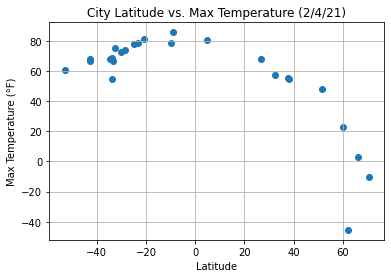

In [11]:
# Values and Initial Plot
x_values = plot_world["Latitude"]
y_values = plot_world["Max Temp"]
plt.scatter(x_values,y_values)
plt.grid(b=True)

# Labelling and Formatting
plt.title(f"City Latitude vs. Max Temperature ({today_date})")
plt.ylabel("Max Temperature (°F)")
plt.xlabel("Latitude")

##### Latitude vs. Humidity

Text(0.5, 0, 'Latitude')

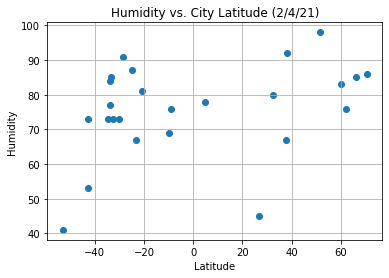

In [12]:
# Values and Initial Plot
x_values = plot_world["Latitude"]
y_values = plot_world["Humidity"]
plt.scatter(x_values,y_values)
plt.grid(b=True)

# Labelling and Formatting
plt.title(f"Humidity vs. City Latitude ({today_date})")
plt.ylabel("Humidity")
plt.xlabel("Latitude")

##### Latitude vs. Cloudiness

Text(0.5, 0, 'Latitude')

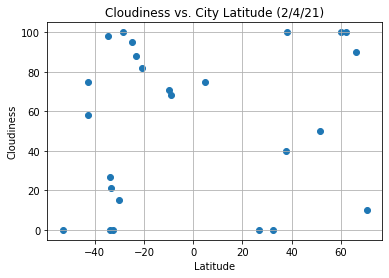

In [13]:
# Values and Initial Plot
x_values = plot_world["Latitude"]
y_values = plot_world["Cloudiness"]
plt.scatter(x_values,y_values)
plt.grid(b=True)

# Labelling and Formatting
plt.title(f"Cloudiness vs. City Latitude ({today_date})")
plt.ylabel("Cloudiness")
plt.xlabel("Latitude")

##### Latitude vs. Wind Speed

Text(0.5, 0, 'Latitude')

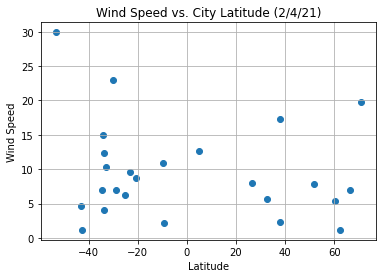

In [14]:
# Values and Initial Plot
x_values = plot_world["Latitude"]
y_values = plot_world["Wind Speed"]
plt.scatter(x_values,y_values)
plt.grid(b=True)

# Labelling and Formatting
plt.title(f"Wind Speed vs. City Latitude ({today_date})")
plt.ylabel("Wind Speed")
plt.xlabel("Latitude")

# Linear Regressions

In [15]:
# Creates northern and southern hemisphere DataFrames.
northern = plot_world[plot_world["Latitude"] >= 0]
southern = plot_world[plot_world["Latitude"] < 0]

##### Northern Hemisphere - Max Temp vs. Latitude Linear Regression

R Value: -0.8480612990042103


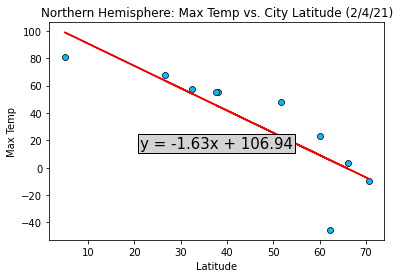

In [16]:
# Values and Initial Plot
x_values = northern["Latitude"]
y_values = northern["Max Temp"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Northern Hemisphere: Max Temp vs. City Latitude ({today_date})")
plt.ylabel("Max Temp")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Southern Hemisphere - Max Temp vs. Latitude Linear Regression

R Value: 0.7940211173502725


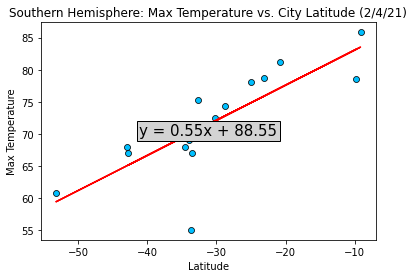

In [17]:
# Sets new value lists for x and y.
x_values = southern["Latitude"]
y_values = southern["Max Temp"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Southern Hemisphere: Max Temperature vs. City Latitude ({today_date})")
plt.ylabel("Max Temperature")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

R Value: 0.3973973543876706


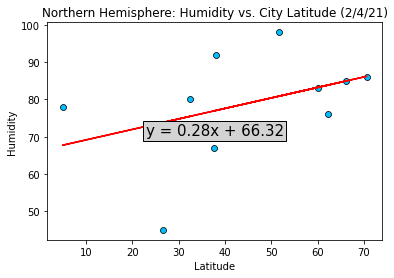

In [18]:
# Values and Initial Plot
x_values = northern["Latitude"]
y_values = northern["Humidity"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Northern Hemisphere: Humidity vs. City Latitude ({today_date})")
plt.ylabel("Humidity")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

R Value: 0.47194020497548744


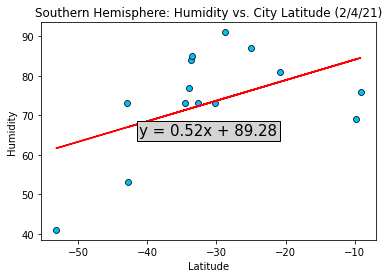

In [19]:
# Values and Initial Plot
x_values = southern["Latitude"]
y_values = southern["Humidity"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Southern Hemisphere: Humidity vs. City Latitude ({today_date})")
plt.ylabel("Humidity")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

R Value: 0.21605973006725585


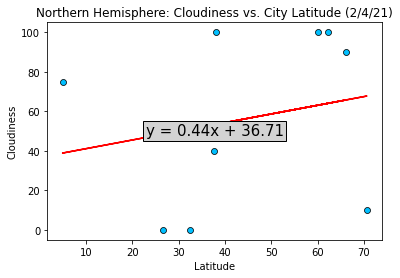

In [20]:
# Values and Initial Plot
x_values = northern["Latitude"]
y_values = northern["Cloudiness"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Northern Hemisphere: Cloudiness vs. City Latitude ({today_date})")
plt.ylabel("Cloudiness")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

R Value: 0.42597835686907026


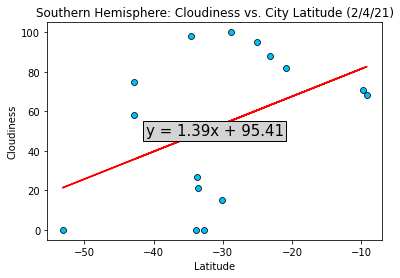

In [21]:
# Values and Initial Plot
x_values = southern["Latitude"]
y_values = southern["Cloudiness"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Southern Hemisphere: Cloudiness vs. City Latitude ({today_date})")
plt.ylabel("Cloudiness")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

R Value: -0.06008849751887692


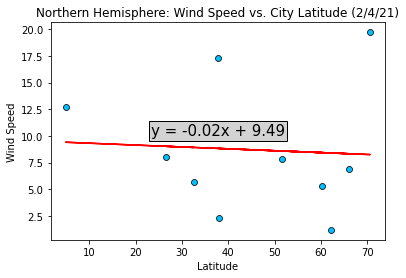

In [22]:
# Values and Initial Plot
x_values = northern["Latitude"]
y_values = northern["Wind Speed"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Northern Hemisphere: Wind Speed vs. City Latitude ({today_date})")
plt.ylabel("Wind Speed")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")

##### Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

R Value: -0.3586101511339642


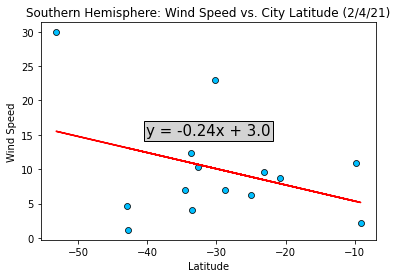

In [23]:
# Values and Initial Plot
x_values = southern["Latitude"]
y_values = southern["Wind Speed"]
plt.scatter(x_values,y_values,c="deepskyblue",edgecolors="black",linewidths=.75)

# Labelling and Formatting
plt.title(f"Southern Hemisphere: Wind Speed vs. City Latitude ({today_date})")
plt.ylabel("Wind Speed")
plt.xlabel("Latitude")

# Regression Stuff
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values,y_values)
regression_line = slope * x_values + intercept
equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
x_pos = (min(x_values)+max(x_values)) / 2
y_pos = (min(y_values)+max(y_values)) / 2
plt.plot(x_values, regression_line, "-", color='red')
# Comment out the below line to see all data points.
plt.annotate(equation,(x_pos,y_pos), fontsize=15, ha="center",va="center",
             bbox=dict(boxstyle="square,pad=0.15", fc="lightgray", lw=1))
    
plt.tight_layout
print(f"R Value: {rvalue}")